###
***Gesture Language Project***
###

Our Vietnamese Sign Language dataset contains 6489 npy files for 44 labels. Each label folder has 147 files except the “H” label, which has 168 files. A single file contains 126 key points for  3 coordinates (x, y, z) which use Mediapipe to detect landmarks in hand videos captured from a webcam.


In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import BatchNormalization, Masking, Bidirectional, GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw, ImageFont
from collections import deque
import time
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

***Generate data***

The dataset includes letters, special characters, and some common gesture phrases:
A, B, C, D, Đ, E, G, H, I, K, L, M, N, O, P, Q, R, S, T, U, V, X, Y, /, ?, \, ~, ., del, space, ^, ', w, Xin chào, Cảm ơn, Tôi, Tên là, 22, tuổi, gặp bạn, rất vui, sống ở, tạm biệt, Thành phố Hồ Chí Minh.

*Special label:
“/”: slash (á, ý, ó, …)
“\”: backslash (à, ò, è,...)
“.”: dot (ạ, ợ, ọ, ẹ,...)
“?”: question (ả, ỏ, ể,...)
“~”: tilde (ã, ễ, ỗ,...)
“`”: (ơ, ư)
“w”: (ă)
“^”: (â, ô, ê)


In [ ]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

os.makedirs("./sign_language_data", exist_ok=True)

def put_vietnamese_text(img, text, position, font_size=32, color=(0, 255, 0)):
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = None
    if font:
        img_pil = Image.fromarray(img)
        draw = ImageDraw.Draw(img_pil)
        draw.text(position, text, font=font, fill=color)
        return np.array(img_pil)
    else:
        cv2.putText(img, text, position, cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
        return img

def sanitize_label(label):
    return label.replace("/", "slash").replace("\\", "backslash").replace("?", "question").replace("~", "tilde").replace(".", "dot")

def normalize_landmarks(landmarks):
    wrist = np.array(landmarks[0])
    palm_center = np.mean([landmarks[9], landmarks[13], landmarks[17]], axis=0)
    base_distance = np.linalg.norm(wrist - palm_center)
    return (landmarks - wrist) / base_distance if base_distance != 0 else np.zeros_like(landmarks)

def augment_landmarks(landmarks, noise_level=0.02):
    return landmarks + np.random.normal(0, noise_level, landmarks.shape)

def collect_sequence(label, sequence_length=30):
    safe_label = sanitize_label(label)
    label_path = os.path.join("sign_language_data", safe_label)
    os.makedirs(label_path, exist_ok=True)
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Không thể mở webcam!")
        return

    print(f"Bắt đầu thu thập dữ liệu cho ký hiệu: {label}")
    print("Nhấn 's' để bắt đầu, 'q' để thoát.")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.flip(frame, 1)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = hands.process(frame_rgb)
        num_hands_detected = len(result.multi_hand_landmarks) if result.multi_hand_landmarks else 0
        
        if result.multi_hand_landmarks:
            for hand_landmarks in result.multi_hand_landmarks:
                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
        
        frame = put_vietnamese_text(frame, f"Nhấn 's' để ghi {label} | Tay: {num_hands_detected}", (10, 30))
        cv2.imshow('Collect Data', frame)
        key = cv2.waitKey(1) & 0xFF

        if key == ord('s'):
            for countdown in range(3, 0, -1):
                ret, frame = cap.read()
                frame = cv2.flip(frame, 1)
                frame = put_vietnamese_text(frame, f"Bắt đầu sau {countdown}", (200, 200), 50, (0, 0, 255))
                cv2.imshow('Collect Data', frame)
                cv2.waitKey(1000)

            sequence = []
            for _ in range(sequence_length):
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.flip(frame, 1)
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                result = hands.process(frame_rgb)
                frame_hands_data = []

                if result.multi_hand_landmarks:
                    for hand_landmarks in result.multi_hand_landmarks:
                        hand_data = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark])
                        norm_hand_data = normalize_landmarks(hand_data)
                        aug_hand_data = augment_landmarks(norm_hand_data)
                        frame_hands_data.append(aug_hand_data.flatten())

                frame_hands_data = frame_hands_data[:2]

                while len(frame_hands_data) < 2:
                    frame_hands_data.append(np.zeros(63))


                sequence.append(np.concatenate(frame_hands_data))
                frame = put_vietnamese_text(frame, f"Ghi ({len(sequence)}/{sequence_length})", (10, 30))
                cv2.imshow('Collect Data', frame)
                time.sleep(0.033)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

            if len(sequence) == sequence_length:
                save_path = os.path.join(label_path, f"{safe_label}_{len(os.listdir(label_path))}.npy")
                np.save(save_path, np.array(sequence))
                print(f"Lưu vào {save_path}")
            else:
                print("Không đủ dữ liệu!")

        if key == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    labels = ["A", "B", "C", "D", "Đ", "E", "G", "H", "I", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "X", "Y", "/", "?", "\\", "~", ".", "del", "space ","^","'","w","Xin chào","cảm ơn","22", "tuổi", "gặp bạn", "rất vui", "sống ở", "tạm biệt", "Thành phố Hồ Chí Minh"]
    for label in labels:
        collect_sequence(label, sequence_length=30)
    print("Hoàn tất thu thập dữ liệu!")


***Augment data***

In [ ]:
def add_noise(landmarks, noise_level=0.01):
    return landmarks + np.random.normal(0, noise_level, landmarks.shape)

def translate_landmarks(landmarks, max_shift=0.05):
    shift = np.random.uniform(-max_shift, max_shift, size=(landmarks.shape[-1],))
    return landmarks + shift

def scale_landmarks(landmarks, scale_range=(0.9, 1.1)):
    scale_factor = np.random.uniform(scale_range[0], scale_range[1])
    return landmarks * scale_factor

def rotate_landmarks(landmarks, angle_range=(-10, 10)):
    angle = np.radians(np.random.uniform(angle_range[0], angle_range[1]))
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle),  0],
        [0, 0, 1]
    ])
    return np.dot(landmarks, rotation_matrix.T)

def mirror_hand(landmarks):
    mirrored = landmarks.copy()
    mirrored[:, 0] *= -1
    return mirrored

def augment_sequence(sequence):
    aug_sequence = []
    for frame in sequence:
        frame = frame.reshape(-1, 3)
        frame = add_noise(frame, 0.01)
        frame = translate_landmarks(frame, 0.03)
        frame = scale_landmarks(frame, (0.95, 1.05))
        frame = rotate_landmarks(frame, (-5, 5))
        aug_sequence.append(frame.flatten())
    return np.array(aug_sequence)

def augment_data(data_dir, num_aug=10):
    for label in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label)
        if os.path.isdir(label_path):
            files = [f for f in os.listdir(label_path) if f.endswith(".npy")]
            
            for file in files:
                file_path = os.path.join(label_path, file)
                sequence = np.load(file_path)
                
                for i in range(num_aug):
                    aug_sequence = augment_sequence(sequence)
                    new_file_name = f"{file.split('.')[0]}_aug{i}.npy"
                    new_file_path = os.path.join(label_path, new_file_name)
                    np.save(new_file_path, aug_sequence)
                    
                    mirrored_sequence = np.array([mirror_hand(frame.reshape(-1, 3)).flatten() for frame in aug_sequence])
                    mirrored_file_name = f"{file.split('.')[0]}_aug{i}_mirrored.npy"
                    mirrored_file_path = os.path.join(label_path, mirrored_file_name)
                    np.save(mirrored_file_path, mirrored_sequence)

DATA_DIR = "./sign_language_data"
augment_data(DATA_DIR, num_aug=3)

***Processing data***

In [ ]:
def load_data(data_dir, feature_size=126):
    sequences, labels = [], []
    
    for label in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                sequence = np.load(file_path)

                if sequence.shape[1] == 63:  
                    padded_sequence = np.zeros((sequence.shape[0], feature_size))
                    padded_sequence[:, :63] = sequence  
                    sequence = padded_sequence  
                elif sequence.shape[1] > feature_size:
                    sequence = sequence[:, :feature_size]
                elif sequence.shape[1] < feature_size:
                    print(f"Warning: File {file_path} has shape {sequence.shape}, continue!")
                    continue

                sequences.append(sequence)
                labels.append(label)
    
    return np.array(sequences), np.array(labels)

DATA_DIR = "./sign_language_data"

X_raw, y_raw = load_data(DATA_DIR, feature_size=126)

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.3, random_state=42)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_raw)
y_test = label_encoder.transform(y_test_raw)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

max_seq_length = 30
X_train = pad_sequences(X_train_raw, maxlen=max_seq_length, dtype='float32', padding='post', truncating='post')
X_test = pad_sequences(X_test_raw, maxlen=max_seq_length, dtype='float32', padding='post', truncating='post')

X_train = (X_train - 0.5) * 2  
X_test = (X_test - 0.5) * 2  

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

***Model training phase***

In [ ]:
model = Sequential([
    Masking(mask_value=0.0, input_shape=(30, 126)),

    Bidirectional(GRU(256, return_sequences=True, activation="tanh")),
    BatchNormalization(),

    Bidirectional(GRU(128, activation="tanh")),
    BatchNormalization(),

    Dense(128, activation="gelu",kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation="gelu",kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation="gelu",kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(len(label_encoder.classes_), activation="softmax")  
])

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("sign_languge_model.keras", save_best_only=True, monitor="val_loss")

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=128,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]
)

print("Best model: sign_languge_model.keras")


c:\Users\giang\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 293ms/step - accuracy: 0.1077 - loss: 4.1237 - val_accuracy: 0.1813 - val_loss: 3.7856
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 260ms/step - accuracy: 0.4101 - loss: 2.5822 - val_accuracy: 0.3883 - val_loss: 3.1911
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - accuracy: 0.6254 - loss: 1.8546 - val_accuracy: 0.5650 - val_loss: 2.4202
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - accuracy: 0.7601 - loss: 1.4282 - val_accuracy: 0.6775 - val_loss: 1.9275
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 257ms/step - accuracy: 0.8643 - loss: 1.0842 - val_accuracy: 0.9065 - val_loss: 0.9638
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - accuracy: 0.9052 - loss: 0.9071 - val_accuracy: 0.8988 - val_loss: 0.7223
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 257ms/step - accuracy: 0.9236 - loss: 0.7814 - val_accuracy: 0.9404 - val_loss: 0.5837
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 258ms/step - accuracy: 0.9446 - loss: 0.6962 - val_accuracy: 0

In [ ]:
model.evaluate(X_test, y_test, verbose=0)

[0.26997125148773193, 0.9928094744682312]

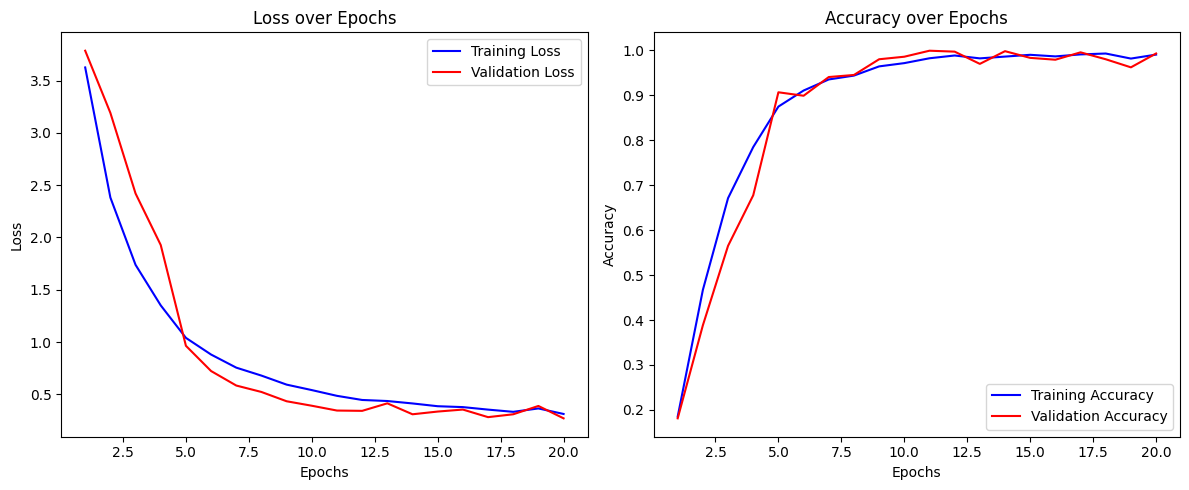

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["loss"], "b", label="Training Loss")
plt.plot(epochs, history.history["val_loss"], "r", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["accuracy"], "b", label="Training Accuracy")
plt.plot(epochs, history.history["val_accuracy"], "r", label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


***Test realtime***

In [ ]:
model = tf.keras.models.load_model("sign_languge_model.keras")

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

font_path = "Arial.ttf"
if not os.path.exists(font_path):
    font_path = "C:/Windows/Fonts/arial.ttf"
font = ImageFont.truetype(font_path, 32)

label_encoder = sorted(os.listdir("./sign_language_data"))

def normalize_landmarks(landmarks):
    wrist = np.array(landmarks[0])
    palm_center = np.mean([landmarks[5], landmarks[9], landmarks[13], landmarks[17]], axis=0)
    base_distance = np.linalg.norm(wrist - palm_center)
    return (landmarks - wrist) / base_distance if base_distance > 0 else np.zeros_like(landmarks)

sequence = []
frame_threshold = 30

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.flip(frame, 1)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = hands.process(frame_rgb)
    
    frame_hands_data = []
    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            hand_data = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark])
            norm_hand_data = normalize_landmarks(hand_data)
            frame_hands_data.append(norm_hand_data.flatten())

    if len(frame_hands_data) == 1:
        frame_hands_data.append(np.zeros(63))
    elif len(frame_hands_data) == 0:
        frame_hands_data = [np.zeros(63), np.zeros(63)]
    
    frame_hands_data = np.concatenate(frame_hands_data)
    
    if frame_hands_data.shape == (126,):
        sequence.append(frame_hands_data)
    
    if len(sequence) > frame_threshold:
        sequence.pop(0)
    
    if len(sequence) == frame_threshold:
        input_data = np.array(sequence)
        if input_data.shape == (frame_threshold, 126):
            input_data = np.expand_dims(input_data, axis=0)
            input_data = (input_data - 0.5) * 2
            prediction = model.predict(input_data, verbose=0)
            predicted_label = label_encoder[np.argmax(prediction)]
            confidence = np.max(prediction)
            
            if confidence >= 0.9:
                frame_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                draw = ImageDraw.Draw(frame_pil)
                draw.text((10, 50), f"Dấu hiệu: {predicted_label} (Độ tin cậy: {confidence:.2%})", font=font, fill=(0, 255, 0))
                frame = cv2.cvtColor(np.array(frame_pil), cv2.COLOR_RGB2BGR)
    
    cv2.imshow("Nhận diện Ngôn ngữ Ký hiệu", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()